In [ ]:
# this notebook was created and tested using Google colab
# so there are two lines below that will need to be commented if running locally

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import files

# comment this line out if running locally
uploaded = files.upload()

Saving lol_data.csv to lol_data (5).csv


In [4]:
import io

# comment this line out if running locally
lol_dataset = io.BytesIO(uploaded['lol_data.csv'])

# keep this wherever running
lol_dataset = pd.read_csv('lol_data.csv')

# Preprocessing

In [5]:
# Get column names
cols = lol_dataset.columns
print(cols)

Index(['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
       'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')


In [6]:
# get labels
y = lol_dataset.blueWins

# get features
drop_cols = ['gameId','blueWins']
x = lol_dataset.drop(drop_cols, axis=1)

In [7]:
# subtract all red columns
x = x.loc[:,~x.columns.str.startswith('red')]
# create kills difference feature
x['killsDiff'] = x['blueKills'] - x['blueDeaths']

# EDA

In [8]:
# going to use normalized data for charts
data = x
data_std = (data - data.mean()) / data.std()
data = pd.concat([y, data_std], axis=1)

## Features ranked by correlation with winning

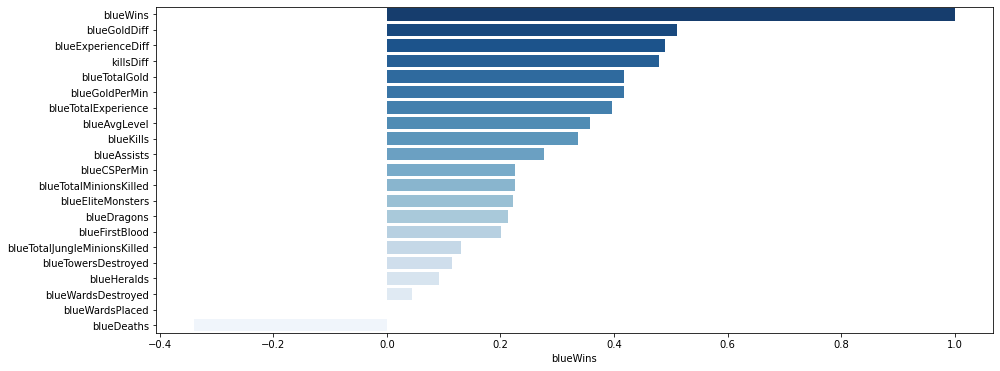

In [9]:
# inspired by https://www.kaggle.com/michalbrezk/how-to-win-league-of-legends
plt.figure(figsize=(15,6))
sorted_features = data.corr()['blueWins'].sort_values(ascending=False)

pal = sns.color_palette("Blues_r", len(sorted_features))
rank = sorted_features.argsort().argsort() 

sns.barplot(y=sorted_features.index, x=sorted_features, palette=np.array(pal[::-1])[rank])

plt.show()

## Ranges and variance of features

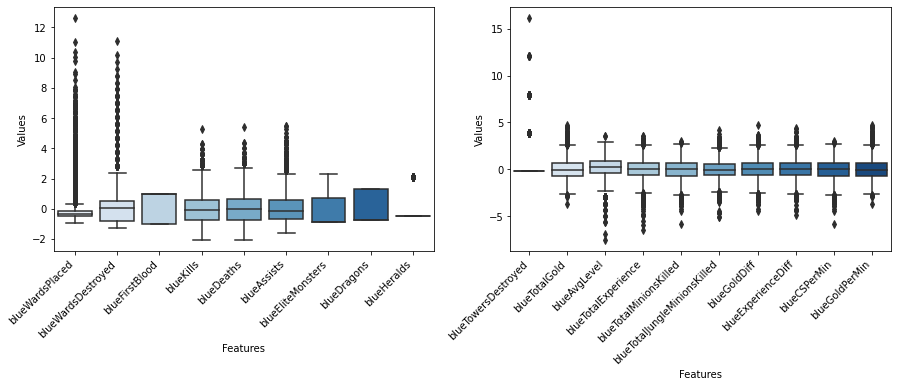

In [10]:
# code adapted from https://www.kaggle.com/christianmcb/league-of-legends-diamond-classification

data = x
data_std = (data - data.mean()) / data.std()
data = pd.concat([y, data_std.iloc[:, 0:9]], axis=1)
data = pd.melt(data, id_vars='blueWins', var_name='Features', value_name='Values')

fig, ax = plt.subplots(1,2,figsize=(15,5))

sns.boxplot(x='Features', y='Values',  data=data, ax=ax[0], palette='Blues')
fig.autofmt_xdate(rotation=45)

data = x
data_std = (data - data.mean()) / data.std()
data = pd.concat([y, data_std.iloc[:, 9:19]], axis=1)
data = pd.melt(data, id_vars='blueWins', var_name='Features', value_name='Values')


sns.boxplot(x='Features', y='Values',  data=data, ax=ax[1], palette='Blues')
fig.autofmt_xdate(rotation=45)

plt.show()

## What if we only used 2 features?

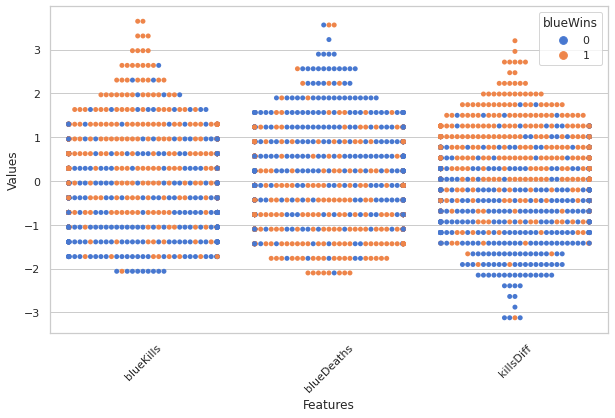

In [11]:
sns.set(style='whitegrid', palette='muted')

data = x[['blueKills','blueDeaths','killsDiff']].sample(1000)
data_std = (data - data.mean()) / data.std()
data = pd.concat([y, data_std], axis=1)
data = pd.melt(data, id_vars='blueWins', var_name='Features', value_name='Values')

plt.figure(figsize=(10,6))
sns.swarmplot(x='Features', y='Values', hue='blueWins', data=data)
plt.xticks(rotation=45)
plt.show()

## Kills and experience

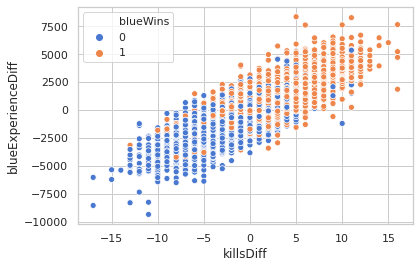

In [12]:
data = pd.concat([y, x], axis=1)
sns.scatterplot(x='killsDiff', y='blueExperienceDiff', hue='blueWins', data=data)
plt.show()

## Kills and gold

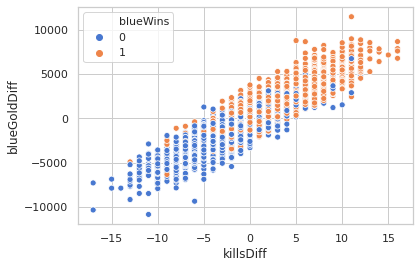

In [13]:
data = pd.concat([y, x], axis=1)
sns.scatterplot(x='killsDiff', y='blueGoldDiff', hue='blueWins', data=data)
plt.show()

## PCA

Text(0, 0.5, 'Second Principal COmp')

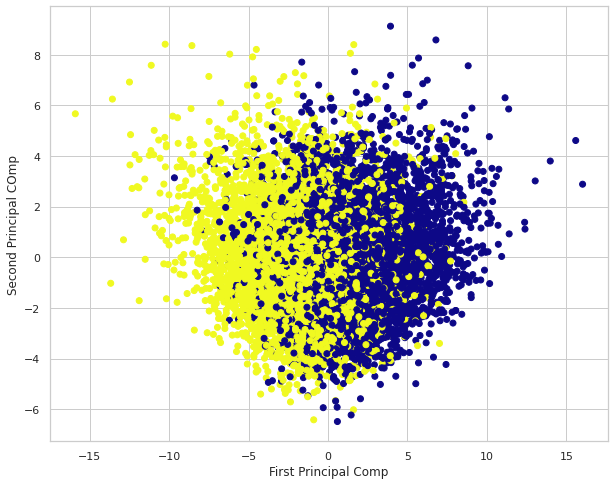

In [14]:
# PCA technique from https://www.kaggle.com/adityaaggarwal09/legendary-game-prediction-analysis

from sklearn.decomposition import PCA
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler

x_pca=lol_dataset.drop('blueWins',axis=1)
y_pca=lol_dataset['blueWins']
x_pca=StandardScaler().fit_transform(x_pca)
pca=PCA(n_components=2)

components=pca.fit_transform(x_pca)

plt.figure(figsize=(10,8))
plt.scatter(components[:,0],components[:,1],c=y_pca,cmap='plasma')
plt.xlabel('First Principal Comp')
plt.ylabel('Second Principal COmp')

# Machine Learning

In [15]:
# Import libraries for machine learning models
from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


## Standardize data

In [16]:
X = preprocessing.StandardScaler().fit(x).transform(x.astype(float))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [17]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Algorithm', 'Accuracy', 'Recall', 'Precision', 'F-Score']

## Prepare table for reporting

In [18]:
# function from https://www.kaggle.com/christianmcb/league-of-legends-diamond-classification

def get_confusion_matrix(algorithm, y_pred, y_actual):
    # Create confusion matrix and interpret values
    con = confusion_matrix(y_test, y_pred)
    tp, fn, fp, tn = con[0][0], con[0][1], con[1][0], con[1][1]
    algorithm = algorithm
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f_score = (2 * precision * recall) / (recall + precision)
    return algorithm, accuracy, recall, precision, f_score

### K-Nearest Neighbours 

In [19]:
# method from https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

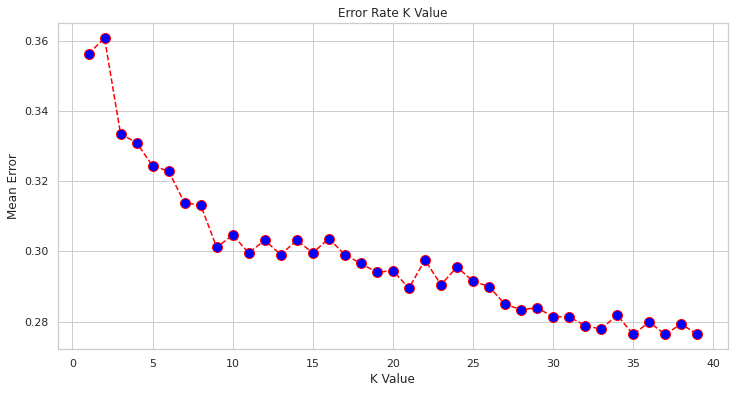

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [21]:
neigh = KNeighborsClassifier(n_neighbors = 30).fit(X_train,y_train)
y_pred = neigh.predict(X_test)

In [22]:
# Call confusion matrix and accuracy
algorithm, accuracy, recall, precision, f_score = get_confusion_matrix('KNN', y_pred, y_test)
print(accuracy)
# Add values to table
table.add_row([algorithm, round(accuracy,5), round(recall,5),
               round(precision,5), round(f_score,5)])

0.7186234817813765


### Decision Trees

In [23]:

# Initialise Decision Tree classifier and predict
tree = DecisionTreeClassifier()

# search the best params
grid = {'min_samples_split': [2, 5, 10, 20, 50, 100],'criterion': ['gini', 'entropy']}

clf_tree = GridSearchCV(tree, grid, cv=5)
clf_tree.fit(X_train, y_train)

y_pred = clf_tree.predict(X_test)

In [24]:
# Call confusion matrix and accuracy
algorithm, accuracy, recall, precision, f_score = get_confusion_matrix('Decision', y_pred, y_test)
print(accuracy)

# Add values to table
table.add_row([algorithm, round(accuracy,5), round(recall,5),
               round(precision,5), round(f_score,5)])

0.6938259109311741


### Logistic Regression

In [25]:
# Train and predict logistic regression model
LR = LogisticRegression()
grid = {'penalty': ['l1','l2','elasticnet','none'], 'solver' : [ 'liblinear'], 'C' : [0.01]}
LR_clf = GridSearchCV(LR, grid, cv=5)
# LR = LogisticRegression(C=0.01, solver='liblinear')
LR_clf.fit(X_train,y_train)
y_pred =LR_clf.predict(X_test)
print(y_pred)

[1 0 0 ... 1 0 0]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)


In [26]:
# Call confusion matrix and accuracy
algorithm, accuracy, recall, precision, f_score = get_confusion_matrix('LR', y_pred, y_test)
print(accuracy)

# Add values to table
table.add_row([algorithm, round(accuracy,5), round(recall,5),
               round(precision,5), round(f_score,5)])

0.7449392712550608


### Random Forest

In [27]:
# Instantiate Random Forest Classifier and predict values
clf = RandomForestClassifier(max_depth=2, random_state=0)
y_pred = clf.fit(X_train, y_train).predict(X_test)

In [28]:
# Call confusion matrix and accuracy
algorithm, accuracy, recall, precision, f_score = get_confusion_matrix('R Forest', y_pred, y_test)

# Add values to table
table.add_row([algorithm, round(accuracy,5), round(recall,5),
               round(precision,5), round(f_score,5)])

## Results

In [29]:
print(table)

+-----------+----------+---------+-----------+---------+
| Algorithm | Accuracy |  Recall | Precision | F-Score |
+-----------+----------+---------+-----------+---------+
|    KNN    | 0.71862  | 0.74492 |  0.70617  | 0.72502 |
|  Decision | 0.69383  | 0.67886 |  0.69801  |  0.6883 |
|     LR    | 0.74494  | 0.74085 |   0.7454  | 0.74312 |
|  R Forest | 0.73229  | 0.73374 |  0.73003  | 0.73188 |
+-----------+----------+---------+-----------+---------+
